# Thyroid Cancer Risk Prediction

### Load dataset 

In [95]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [53]:
df = pd.read_csv('thyroid_cancer_risk_data.csv')

In [54]:
print("------ df.shape---------")
print(df.shape)

print("------ df.head---------")
print(df.head())

print("----- df.describe--------")
print(df.describe())

print("----- check for null values -----------")
print(df.isnull().sum())

------ df.shape---------
(212691, 17)
------ df.head---------
   Patient_ID  Age  Gender  Country  Ethnicity Family_History  \
0           1   66    Male   Russia  Caucasian             No   
1           2   29    Male  Germany   Hispanic             No   
2           3   86    Male  Nigeria  Caucasian             No   
3           4   75  Female    India      Asian             No   
4           5   35  Female  Germany    African            Yes   

  Radiation_Exposure Iodine_Deficiency Smoking Obesity Diabetes  TSH_Level  \
0                Yes                No      No      No       No       9.37   
1                Yes                No      No      No       No       1.83   
2                 No                No      No      No       No       6.26   
3                 No                No      No      No       No       4.10   
4                Yes                No      No      No       No       9.10   

   T3_Level  T4_Level  Nodule_Size Thyroid_Cancer_Risk Diagnosis  
0      1.67

In [55]:
# Step 2: Drop irrelevant columns
df = df.drop(columns=['Patient_ID'])  # Not useful for ML

# Step 3: Encode categorical features
# Label encode binary features or use one-hot encoding for others

# Binary Label Encoding
binary_cols = ['Gender', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 
                'Smoking', 'Obesity', 'Diabetes']

label_encoder = LabelEncoder()
for col in binary_cols:
    df[col] = label_encoder.fit_transform(df[col])

# One-Hot Encoding for multi-category features
df = pd.get_dummies(df, columns=['Country', 'Ethnicity', 'Thyroid_Cancer_Risk', 'Diagnosis'], drop_first=True)

# Step 4: Cleaned dataframe
print(df.head())


   Age  Gender  Family_History  Radiation_Exposure  Iodine_Deficiency  \
0   66       1               0                   1                  0   
1   29       1               0                   1                  0   
2   86       1               0                   0                  0   
3   75       0               0                   0                  0   
4   35       0               1                   1                  0   

   Smoking  Obesity  Diabetes  TSH_Level  T3_Level  ...  Country_South Korea  \
0        0        0         0       9.37      1.67  ...                False   
1        0        0         0       1.83      1.73  ...                False   
2        0        0         0       6.26      2.59  ...                False   
3        0        0         0       4.10      2.62  ...                False   
4        0        0         0       9.10      2.11  ...                False   

   Country_UK  Country_USA  Ethnicity_Asian  Ethnicity_Caucasian  \
0       Fals

In [56]:
print("----- df.info-----------")
print(df.info())

#features
X = df.drop(columns=['Diagnosis_Malignant']) 

#label
y = df['Diagnosis_Malignant']

y_new = y.map({'Benign': 0, 'Malignant': 1})
y_new

print("Feature matrix shape:", X.shape)
print("Label vector shape:", y.shape)

----- df.info-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Age                         212691 non-null  int64  
 1   Gender                      212691 non-null  int64  
 2   Family_History              212691 non-null  int64  
 3   Radiation_Exposure          212691 non-null  int64  
 4   Iodine_Deficiency           212691 non-null  int64  
 5   Smoking                     212691 non-null  int64  
 6   Obesity                     212691 non-null  int64  
 7   Diabetes                    212691 non-null  int64  
 8   TSH_Level                   212691 non-null  float64
 9   T3_Level                    212691 non-null  float64
 10  T4_Level                    212691 non-null  float64
 11  Nodule_Size                 212691 non-null  float64
 12  Country_China               212691 non-null  bo

In [57]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
#scale the features to improve performance/prevent features with larger ranges from dominating the model
scaler = StandardScaler()
#fit scaler to training set, transform training set, use same mean and standard deviation from training to transform testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
# Random Forest

my_RandomForest = RandomForestClassifier(n_estimators = 29, bootstrap = True, random_state=2)

# fitting the model to the training data
my_RandomForest.fit(X_train_scaled, y_train)

# make predictions on the testing set
y_predict_rf = my_RandomForest.predict(X_test_scaled)

#get the accuracy score and print
rf_accuracy = accuracy_score(y_test, y_predict_rf)
print('Random Forest Accuracy:', rf_accuracy)


#AUC

#estimating the probability of each label 
y_predict_prob_rf = my_RandomForest.predict_proba(X_test_scaled)

# estimated likelihood of label=1 for the testing set
y_prob_rf = y_predict_prob_rf[:, 1] 

#false positive rate (fpr) and true positive rate (tpr)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_prob_rf, pos_label=1)

AUC_rf = metrics.auc(fpr_rf, tpr_rf)
print('Area Under Curve for ROC', AUC_rf)

Random Forest Accuracy: 0.8228592026078235
Area Under Curve for ROC 0.6942702580034051


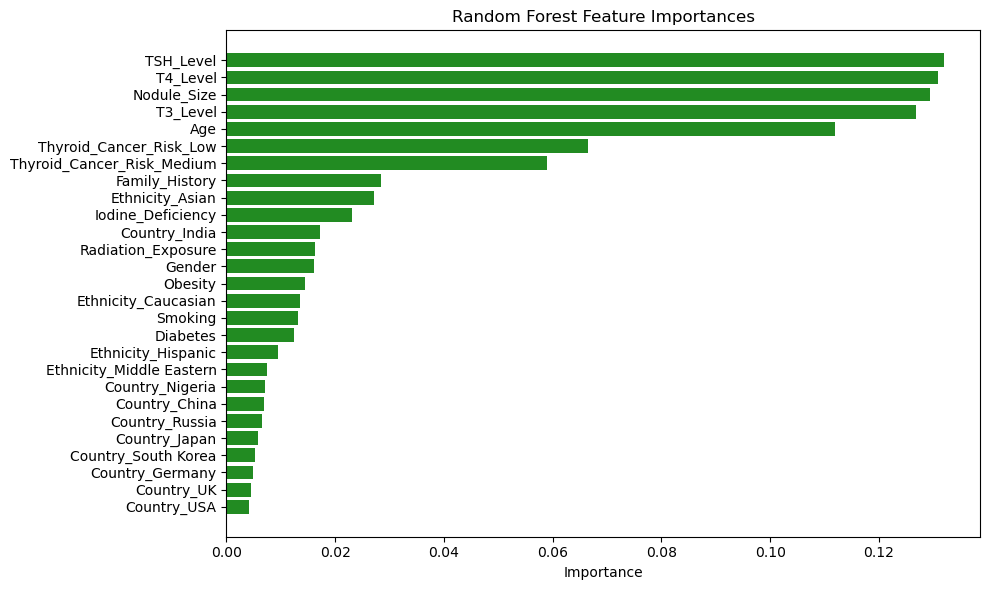

In [106]:
importances = my_RandomForest.feature_importances_

feature_names = df.columns[:-1]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='forestgreen')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()


In [60]:
# Decision Tree

my_DecisionTree = DecisionTreeClassifier(random_state=2)

# fitting the model to the training data
my_DecisionTree.fit(X_train_scaled, y_train)

# make predictions on the testing set
y_predict_dt = my_DecisionTree.predict(X_test_scaled)

#get the accuracy score and print
dt_accuracy = accuracy_score(y_test, y_predict_dt)
print('Decision Tree Accuracy:', dt_accuracy)

#AUC 

#estimating the probability of each label 
y_predict_prob_dt = my_DecisionTree.predict_proba(X_test_scaled)

# estimated likelihood of label=1 for the testing set
y_prob = y_predict_prob_dt[:, 1] 

#false positive rate (fpr) and true positive rate (tpr)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, y_prob, pos_label=1)

AUC_dt = metrics.auc(fpr_dt, tpr_dt)
print('Area Under Curve for ROC', AUC_dt)

Decision Tree Accuracy: 0.7049429538615848
Area Under Curve for ROC 0.6014787152474963


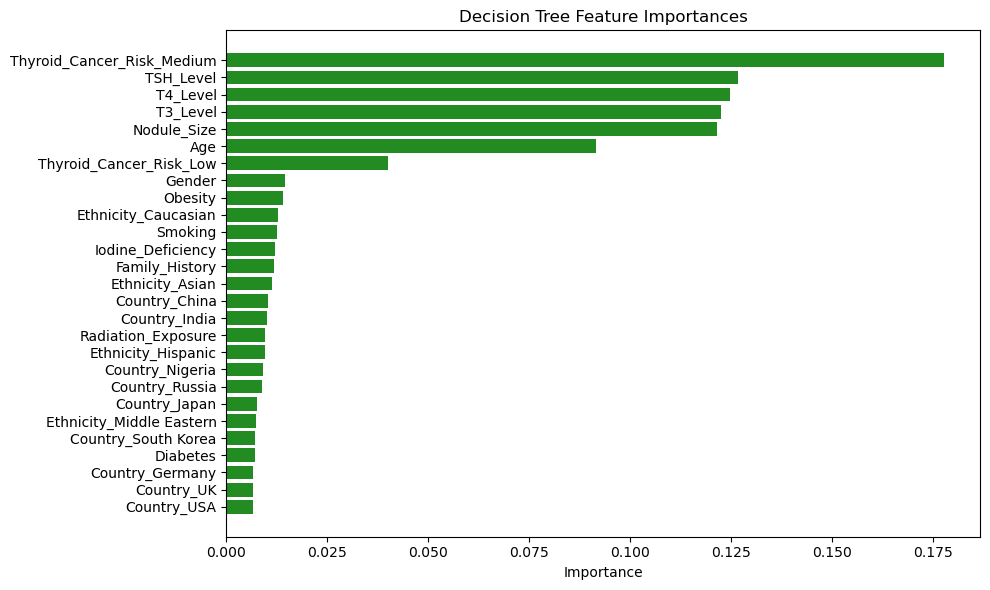

In [114]:
importances = my_DecisionTree.feature_importances_

feature_names = df.columns[:-1]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='forestgreen')
plt.xlabel('Importance')
plt.title('Decision Tree Feature Importances')
plt.tight_layout()
plt.show()

In [61]:
# AdaBoost

my_AdaBoost = AdaBoostClassifier(n_estimators = 29,random_state=2)

# fitting the model to the training data
my_AdaBoost.fit(X_train_scaled, y_train)

# make predictions on the testing set
y_predict_ab = my_AdaBoost.predict(X_test_scaled)

#get the accuracy score and print
ab_accuracy = accuracy_score(y_test, y_predict_ab)
print('Adaboost Accuracy:', ab_accuracy)


# AUC

#estimating the probability of each label 
y_predict_prob_ab = my_AdaBoost.predict_proba(X_test_scaled)

# estimated likelihood of label=1 for the testing set
y_prob_ab = y_predict_prob_ab[:, 1] 

#false positive rate (fpr) and true positive rate (tpr)
fpr_ab, tpr_ab, thresholds_ab = metrics.roc_curve(y_test, y_prob_ab, pos_label=1)

AUC_ab = metrics.auc(fpr_ab, tpr_ab)
print('Area Under Curve for ROC', AUC_ab)

Adaboost Accuracy: 0.8260092778335005
Area Under Curve for ROC 0.6971085490475853


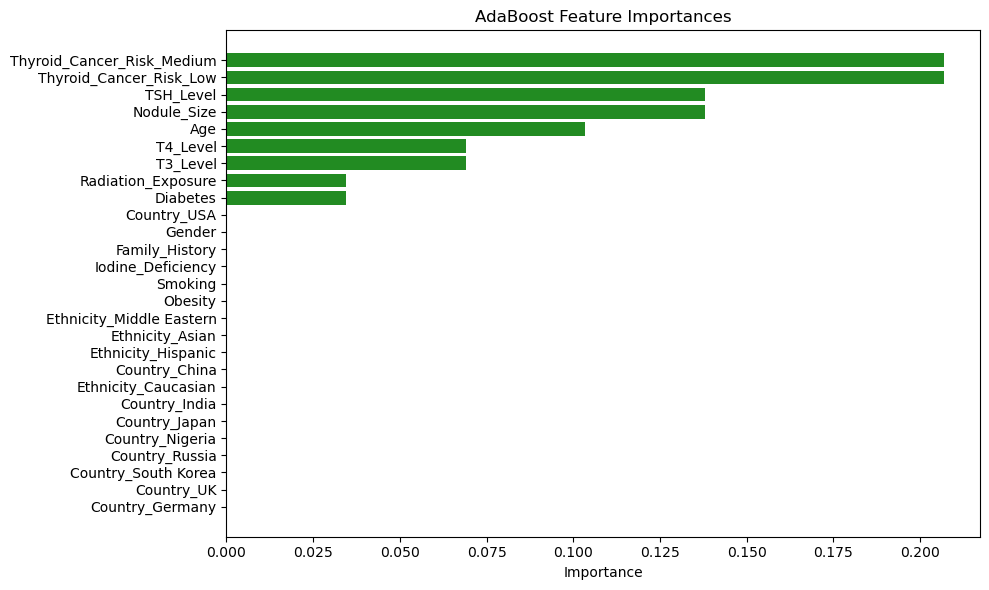

In [115]:
importances = my_AdaBoost.feature_importances_

feature_names = df.columns[:-1]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='forestgreen')
plt.xlabel('Importance')
plt.title('AdaBoost Feature Importances')
plt.tight_layout()
plt.show()

In [62]:
# XGBoost

my_XGBoost = XGBClassifier(n_estimators = 29,random_state=2)

# fitting the model to the training data
my_XGBoost.fit(X_train_scaled, y_train)

# make predictions on the testing set
y_predict_xg = my_XGBoost.predict(X_test_scaled)

#get the accuracy score and print
xg_accuracy = accuracy_score(y_test, y_predict_xg)
print('XGBoost Accuracy:', xg_accuracy)


# AUC

#estimating the probability of each label 
y_predict_prob_xg = my_XGBoost.predict_proba(X_test_scaled)

# estimated likelihood of label=1 for the testing set
y_prob_xg = y_predict_prob_xg[:, 1] 

#false positive rate (fpr) and true positive rate (tpr)
fpr_xg, tpr_xg, thresholds_xg = metrics.roc_curve(y_test, y_prob_xg, pos_label=1)

AUC_xg = metrics.auc(fpr_xg, tpr_xg)
print('Area Under Curve for ROC', AUC_xg)

XGBoost Accuracy: 0.8257898696088265
Area Under Curve for ROC 0.6928483952208633


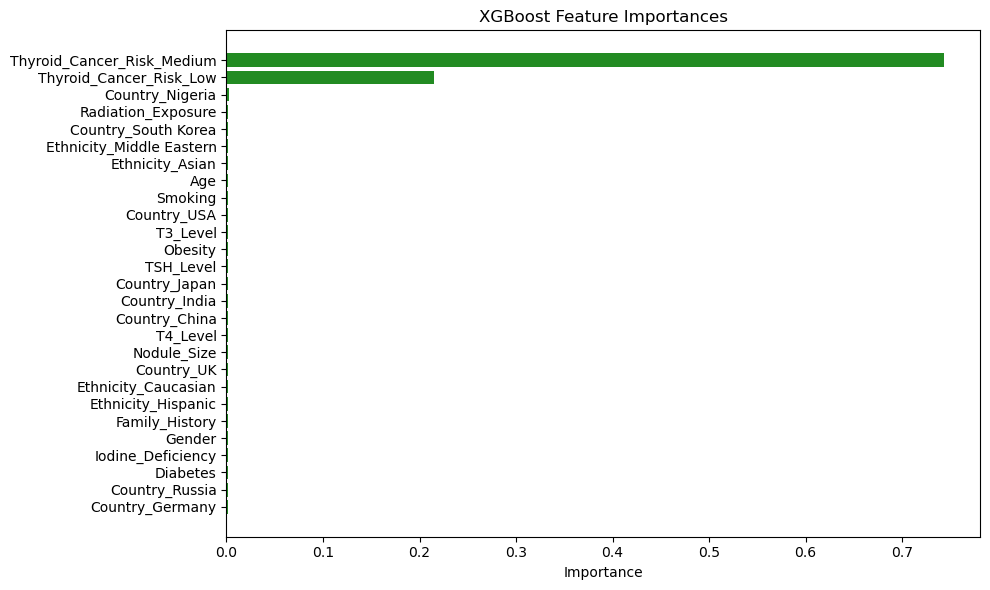

In [116]:
importances = my_XGBoost.feature_importances_

feature_names = df.columns[:-1]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='forestgreen')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()

In [63]:
#Logistic Regression

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_predict_logistical = log_reg.predict(X_test_scaled)
log_score = accuracy_score(y_test, y_predict_logistical)
print(f"Logistical Regression Accuracy: {log_score}")

y_predict_prob_logstical = log_reg.predict_proba(X_test_scaled)
y_prob_logistical = y_predict_prob_logstical[:, 1]
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, y_prob_logistical, pos_label=1)
AUC_lr = metrics.auc(fpr_lr, tpr_lr)
print(f"Area Under Curve for ROC", AUC_lr)

Logistical Regression Accuracy: 0.8260092778335005
Area Under Curve for ROC 0.6958852038502208


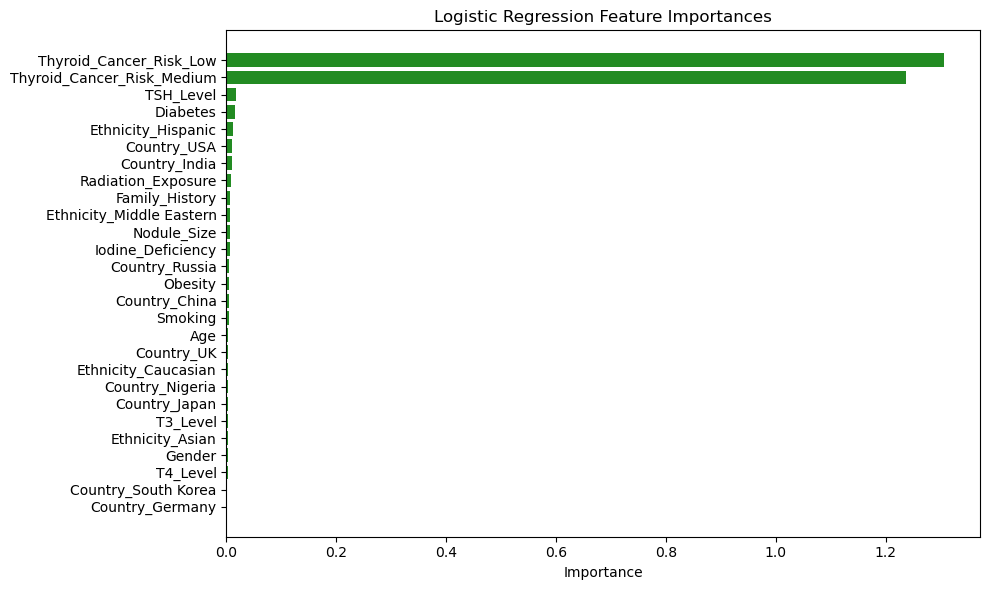

In [117]:
importances = abs(log_reg.coef_[0]) 
feature_names = X.columns 

importance_dict = dict(zip(feature_names, importances))

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='forestgreen')
plt.xlabel('Importance')
plt.title('Logistic Regression Feature Importances')
plt.tight_layout()
plt.show()

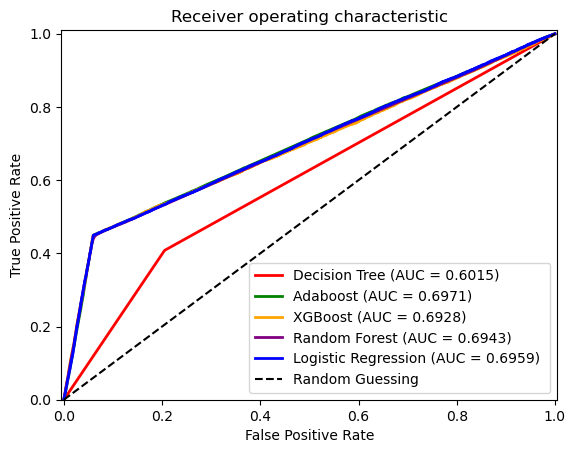

In [64]:
%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label='Decision Tree (AUC = %0.4f)' % AUC_dt)
plt.plot(fpr_ab, tpr_ab, color='green', lw=2, label='Adaboost (AUC = %0.4f)' % AUC_ab)
plt.plot(fpr_xg, tpr_xg,color='orange', lw=2, label='XGBoost (AUC = %0.4f)' % AUC_xg)
plt.plot(fpr_rf, tpr_rf,color='purple', lw=2, label='Random Forest (AUC = %0.4f)' % AUC_rf)
plt.plot(fpr_lr, tpr_lr, color="blue", lw=2, label="Logistic Regression (AUC = %0.4f) " %AUC_lr)

# Random Guess line:
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

## SVM

### Split the data

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Encode the label to 1 or 0

In [66]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

### Normalize the features

In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Perform PCA to reduce the dimension

In [68]:
k = 8
my_pca = PCA(n_components = k)
X_train_new = my_pca.fit_transform(X_train_scaled)
X_test_new = my_pca.transform(X_test_scaled)

### Using Support Vector Machine Model

In [69]:
svm = SVC(probability=True)

In [70]:
svm.fit(X_train_new, y_train_encoded)

SVC(probability=True)

In [71]:
y_predict = svm.predict(X_test_new)

In [72]:
accuracy = accuracy_score(y_test_encoded, y_predict)

In [73]:
accuracy

0.8280518308163918

### Plot the ROC Curve

In [74]:
y_scores = svm.predict_log_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

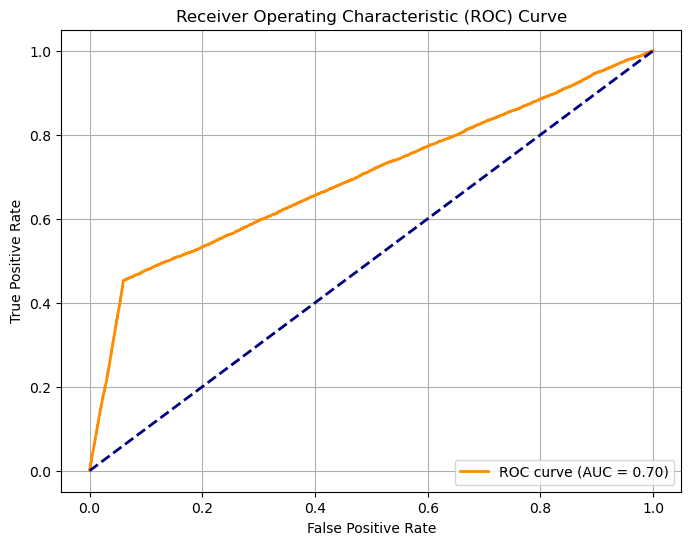

In [75]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Explained variance ratio: [0.06439155 0.05191859]


/var/folders/wd/l8n5ln7s4h92zgdgfplyw4380000gn/T/ipykernel_18420/335904184.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca_lr[:, 0], X_pca_lr[:, 1], cmap='viridis')


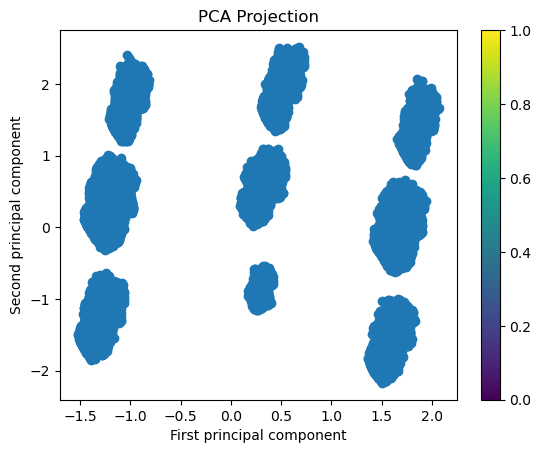

In [76]:
pca_lr = PCA(n_components=2)

X_pca_lr = pca_lr.fit_transform(X_train_scaled)

print("Explained variance ratio:", pca_lr.explained_variance_ratio_)

plt.scatter(X_pca_lr[:, 0], X_pca_lr[:, 1], cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA Projection')
plt.colorbar()
plt.show()

In [77]:
loadings_lr = pd.DataFrame(pca_lr.components_.T, columns=[f'PC{i+1}' for i in range(pca_lr.n_components_)], index=X.columns)
print(loadings_lr)

                                 PC1       PC2
Age                         0.002386 -0.003191
Gender                     -0.003662 -0.019617
Family_History              0.036677  0.032008
Radiation_Exposure          0.019123  0.073606
Iodine_Deficiency           0.023471  0.051126
Smoking                     0.000663  0.003135
Obesity                    -0.005305  0.004332
Diabetes                   -0.001462  0.023022
TSH_Level                  -0.005831  0.025199
T3_Level                    0.005807 -0.015410
T4_Level                    0.009390 -0.020953
Nodule_Size                 0.011257  0.007210
Country_China              -0.024637 -0.030456
Country_Germany            -0.007853 -0.037684
Country_India               0.048679  0.103308
Country_Japan              -0.009114  0.055765
Country_Nigeria            -0.003472 -0.045987
Country_Russia             -0.007529  0.000649
Country_South Korea         0.000109 -0.021810
Country_UK                 -0.006609 -0.030632
Country_USA  

/var/folders/wd/l8n5ln7s4h92zgdgfplyw4380000gn/T/ipykernel_18420/449557740.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


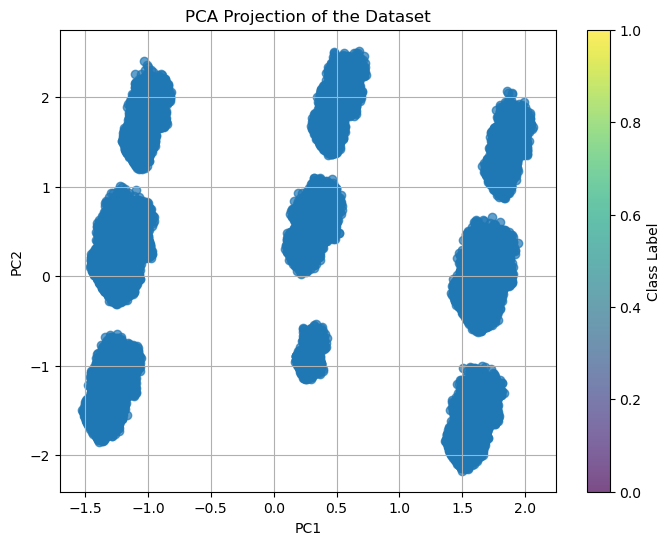

In [78]:
# Cancer PC1: influenced by thyroid cancer risk
# PC2: influenced by ethnicity Caucasian and Asian
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca_lr[:, 0],
    X_pca_lr[:, 1],
    cmap='viridis',
    alpha=0.7
)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection of the Dataset')
plt.colorbar(scatter, label='Class Label')
plt.grid(True)
plt.show()

# Data Visualization

### Heatmap correlation

In [79]:
# Calculate correlations between columns
cancer_cor = df.corr()

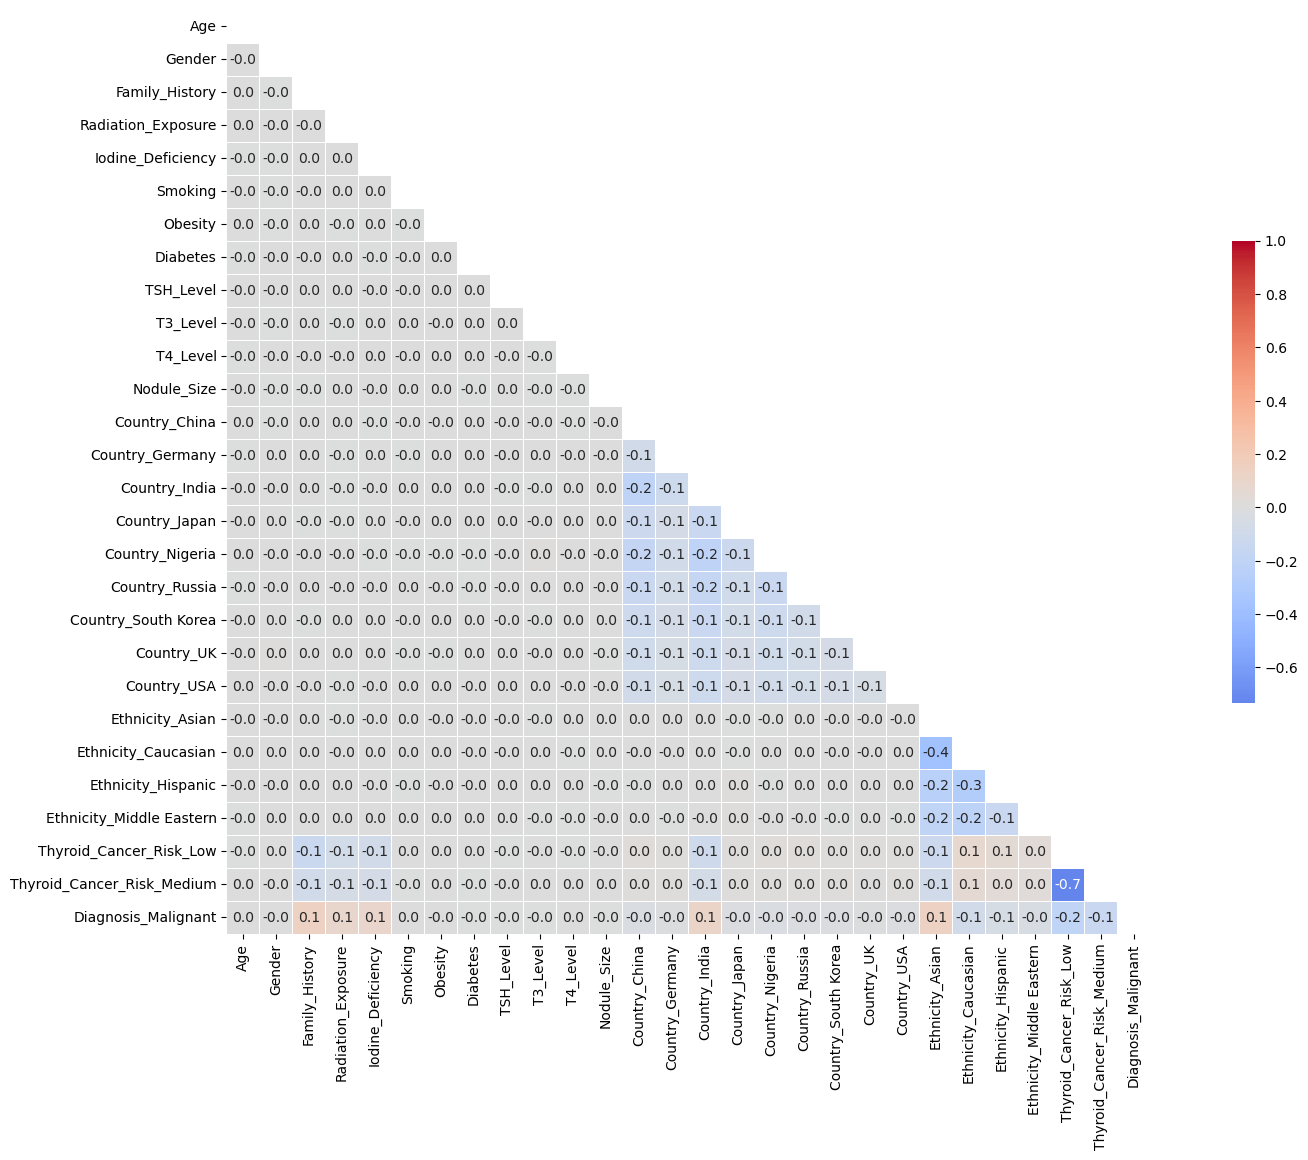

In [80]:
# Creating mask to hide the upper triangle of the heatmap
mask = np.triu(np.ones_like(cancer_cor, dtype=bool))

# Def heatmap
f, ax = plt.subplots(figsize=(21,12))

# Draw heatmap
cancer_cor = sns.heatmap(
    cancer_cor, mask=mask, vmax=1.0, center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5}, annot=True, fmt='.1f', cmap='coolwarm'
)

plt.show()


### Scatter Plot

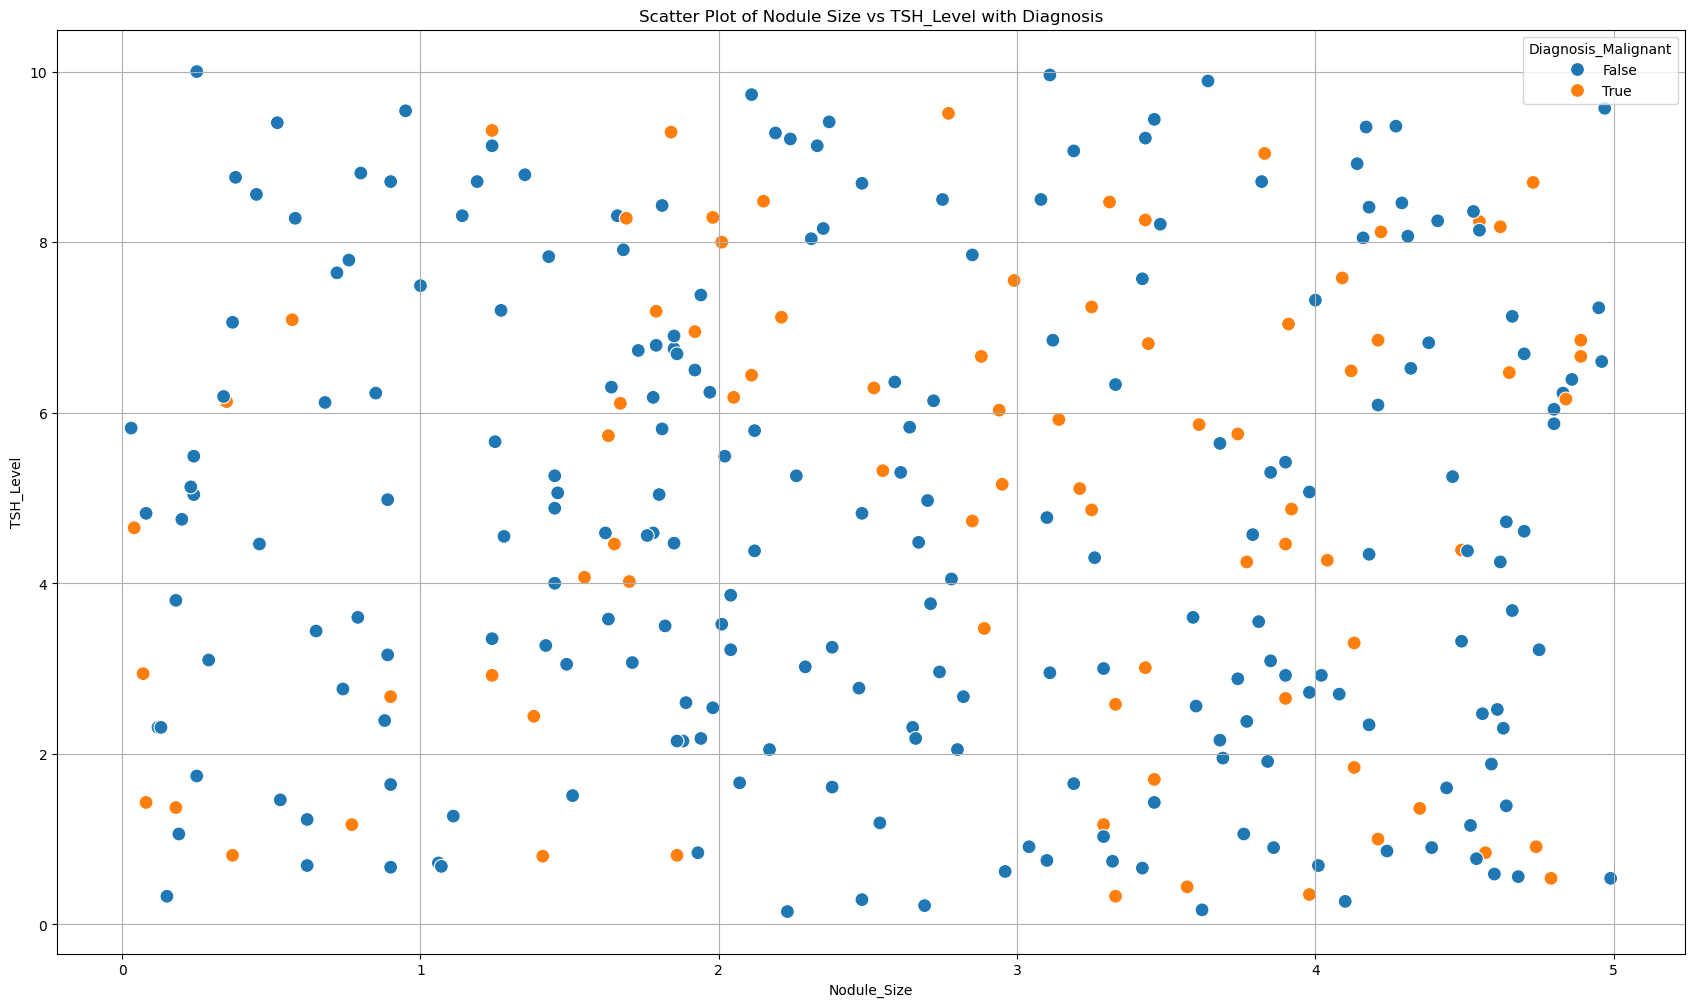

In [81]:
plt.figure(figsize=(21,12))
sns.scatterplot(x = 'Nodule_Size', y = 'TSH_Level', hue='Diagnosis_Malignant', data=df.sample(300), s = 100)
plt.title("Scatter Plot of Nodule Size vs TSH_Level with Diagnosis")
plt.grid(True)
plt.show()


## Splitting Dataset 20% & ANN Classifier 


### ANN Classifier 1

In [82]:
X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(X, y_new, test_size=0.2, random_state=2)

In [83]:
my_ANN1 = MLPClassifier(hidden_layer_sizes=(20,10), activation= 'logistic', 
                       solver='adam', alpha=1e-5, random_state=1, 
                       learning_rate_init = 0.001, verbose=True, max_iter = 500, tol=0.0001)

In [84]:
my_ANN1.fit(X_train, y_train)

Iteration 1, loss = 0.51906304
Iteration 2, loss = 0.46066257
Iteration 3, loss = 0.45485847
Iteration 4, loss = 0.45362252
Iteration 5, loss = 0.45304341
Iteration 6, loss = 0.45289139
Iteration 7, loss = 0.45257958
Iteration 8, loss = 0.45246765
Iteration 9, loss = 0.45242419
Iteration 10, loss = 0.45233595
Iteration 11, loss = 0.45233830
Iteration 12, loss = 0.45232077
Iteration 13, loss = 0.45216665
Iteration 14, loss = 0.45228651
Iteration 15, loss = 0.45219808
Iteration 16, loss = 0.45218264
Iteration 17, loss = 0.45218236
Iteration 18, loss = 0.45216267
Iteration 19, loss = 0.45211400
Iteration 20, loss = 0.45215094
Iteration 21, loss = 0.45210387
Iteration 22, loss = 0.45206723
Iteration 23, loss = 0.45204372
Iteration 24, loss = 0.45204055
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=(20, 10),
              max_iter=500, random_state=1, verbose=True)

In [85]:
y_pred1 = my_ANN1.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred1))

Test Accuracy: 0.8280518308163918


### ANN Classifier 2

In [86]:
my_ANN2 = MLPClassifier(hidden_layer_sizes=(20,10,20), activation= 'relu', 
                       solver='adam', alpha=1e-5, random_state=1, 
                       learning_rate_init = 0.000001, verbose=True,max_iter = 1000, tol=0.0000001)
my_ANN2.fit(X_train, y_train)

Iteration 1, loss = 3.27613210
Iteration 2, loss = 3.17440591
Iteration 3, loss = 3.07431232
Iteration 4, loss = 2.97556987
Iteration 5, loss = 2.87813212
Iteration 6, loss = 2.78200215
Iteration 7, loss = 2.68715534
Iteration 8, loss = 2.59366114
Iteration 9, loss = 2.50155553
Iteration 10, loss = 2.41096124
Iteration 11, loss = 2.32194555
Iteration 12, loss = 2.23457188
Iteration 13, loss = 2.14886697
Iteration 14, loss = 2.06502942
Iteration 15, loss = 1.98314370
Iteration 16, loss = 1.90326912
Iteration 17, loss = 1.82553503
Iteration 18, loss = 1.75009241
Iteration 19, loss = 1.67697689
Iteration 20, loss = 1.60627038
Iteration 21, loss = 1.53809216
Iteration 22, loss = 1.47257953
Iteration 23, loss = 1.40978784
Iteration 24, loss = 1.34974800
Iteration 25, loss = 1.29253280
Iteration 26, loss = 1.23815936
Iteration 27, loss = 1.18663778
Iteration 28, loss = 1.13793957
Iteration 29, loss = 1.09199232
Iteration 30, loss = 1.04866995
Iteration 31, loss = 1.00791566
Iteration 32, los

/opt/anaconda3/envs/tensorflowEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(20, 10, 20),
              learning_rate_init=1e-06, max_iter=1000, random_state=1,
              tol=1e-07, verbose=True)

In [87]:
y_pred2 = my_ANN2.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred2))

Test Accuracy: 0.8278449589077164


### ANN Classifer 3

In [88]:
my_ANN3 = MLPClassifier(hidden_layer_sizes=(50,30,20,10), activation= 'relu', 
                       solver='adam', alpha=1e-4, random_state=1, 
                       learning_rate_init = 0.0001, verbose=True,max_iter = 2000, tol=0.0000001)
my_ANN3.fit(X_train, y_train)

Iteration 1, loss = 0.56597797
Iteration 2, loss = 0.51184786
Iteration 3, loss = 0.48698111
Iteration 4, loss = 0.47439355
Iteration 5, loss = 0.46659332
Iteration 6, loss = 0.46145237
Iteration 7, loss = 0.45773037
Iteration 8, loss = 0.45581925
Iteration 9, loss = 0.45471969
Iteration 10, loss = 0.45404921
Iteration 11, loss = 0.45368895
Iteration 12, loss = 0.45346674
Iteration 13, loss = 0.45353053
Iteration 14, loss = 0.45332476
Iteration 15, loss = 0.45306361
Iteration 16, loss = 0.45297679
Iteration 17, loss = 0.45317223
Iteration 18, loss = 0.45298140
Iteration 19, loss = 0.45283293
Iteration 20, loss = 0.45281611
Iteration 21, loss = 0.45282603
Iteration 22, loss = 0.45278987
Iteration 23, loss = 0.45272429
Iteration 24, loss = 0.45272087
Iteration 25, loss = 0.45296405
Iteration 26, loss = 0.45256140
Iteration 27, loss = 0.45282444
Iteration 28, loss = 0.45259981
Iteration 29, loss = 0.45252994
Iteration 30, loss = 0.45249877
Iteration 31, loss = 0.45252104
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(50, 30, 20, 10), learning_rate_init=0.0001,
              max_iter=2000, random_state=1, tol=1e-07, verbose=True)

In [89]:
y_pred3 = my_ANN3.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred3))

Test Accuracy: 0.8279201850563256


In [90]:
y_predict_ann = my_ANN3.predict(X_test)
print("Test Accuracy ANN3:", accuracy_score(y_test, y_pred2))

Test Accuracy ANN3: 0.8278449589077164


## TPR, FPR ,AUC & ROC Curve

In [91]:
y_prob = my_ANN3.predict_proba(X_test)[:, 1]  # Probabilities for Malignant (class 1)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)

AUC Score: 0.6967946552621329


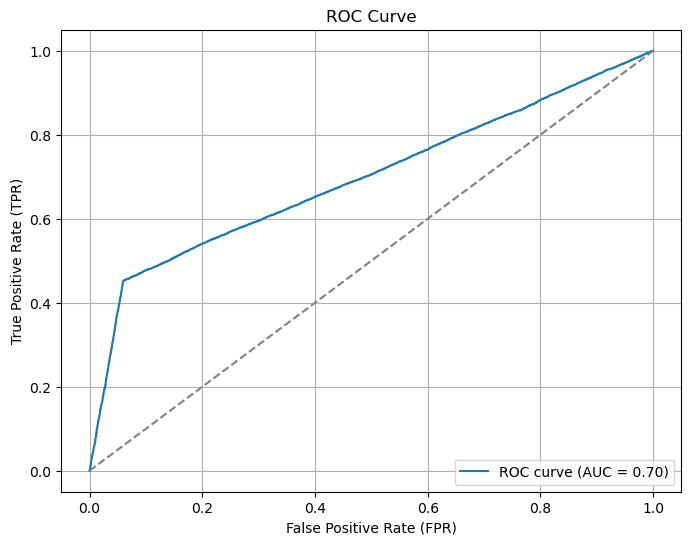

In [92]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random guess
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Cross- Validation 10-Fold

In [100]:
from sklearn.model_selection import cross_val_score

my_ANN4 = MLPClassifier(hidden_layer_sizes=(10,20,10), activation= 'relu', 
                       solver='adam', alpha=1e-4, random_state=1, 
                       learning_rate_init = 0.001, verbose=True, tol=0.00001)

accuracy_list = cross_val_score(my_ANN4, X, y, cv=10, scoring='accuracy')

print('\n\n','accuracy: ',accuracy_list)

accuracy_cv = accuracy_list.mean()

print(accuracy_cv)

Iteration 1, loss = 0.50617128
Iteration 2, loss = 0.45549764
Iteration 3, loss = 0.45200188
Iteration 4, loss = 0.45175738
Iteration 5, loss = 0.45148835
Iteration 6, loss = 0.45145724
Iteration 7, loss = 0.45147510
Iteration 8, loss = 0.45152692
Iteration 9, loss = 0.45137004
Iteration 10, loss = 0.45137728
Iteration 11, loss = 0.45127191
Iteration 12, loss = 0.45133035
Iteration 13, loss = 0.45128571
Iteration 14, loss = 0.45127573
Iteration 15, loss = 0.45127600
Iteration 16, loss = 0.45127581
Iteration 17, loss = 0.45129106
Iteration 18, loss = 0.45121151
Iteration 19, loss = 0.45121437
Iteration 20, loss = 0.45119640
Iteration 21, loss = 0.45127773
Iteration 22, loss = 0.45114585
Iteration 23, loss = 0.45115643
Iteration 24, loss = 0.45115144
Iteration 25, loss = 0.45113407
Iteration 26, loss = 0.45116921
Iteration 27, loss = 0.45110740
Iteration 28, loss = 0.45107240
Iteration 29, loss = 0.45112334
Iteration 30, loss = 0.45111813
Iteration 31, loss = 0.45109679
Iteration 32, los

In [101]:
accuracy_cv = accuracy_list.mean()

print(accuracy_cv)

0.827303461383669
